# 한강공원 주차 예측

### 초기 세팅

In [1]:
# pip install requests
import warnings
warnings.filterwarnings('ignore')

In [88]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

### 한강공원 API

In [ ]:
import requests
import json
import time

# API 데이터 요청 함수
def fetch_data(url):
    # 주어진 URL로 GET 요청을 보내고 응답을 받음
    response = requests.get(url)
    
    # 응답 상태 코드가 200(성공)이면 JSON 데이터를 반환
    if response.status_code == 200:
        return response.json()
    else:
        # 상태 코드가 200이 아니면 오류 메시지 출력
        print(f"Error: {response.status_code}")
        return None

# 실시간 인구 및 혼잡도 정보 추출 함수
def extract_congestion_info(city_data):
    # 'LIVE_PPLTN_STTS' 키로부터 실시간 인구 현황 데이터 추출
    live_ppltn = city_data.get('LIVE_PPLTN_STTS', [])
    # 첫 번째 인구 정보 항목을 가져오거나 없으면 빈 딕셔너리 반환
    congestion_info = live_ppltn[0] if live_ppltn else {}
    
    # 추출한 데이터를 딕셔너리 형태로 반환
    return {
        "장소명": city_data.get("AREA_NM", "정보 없음"),  # 장소명
        "장소 코드": city_data.get("AREA_CD", "정보 없음"),  # 장소 코드
        "장소 혼잡도 지표": congestion_info.get("AREA_CONGEST_LVL", "정보 없음"),  # 혼잡도 지표
        "장소 혼잡도 지표 관련 메세지": congestion_info.get("AREA_CONGEST_MSG", "정보 없음"),  # 혼잡도 메세지
        "실시간 인구 현황": congestion_info.get("AREA_PPLTN_MIN", "정보 없음") + " ~ " + congestion_info.get("AREA_PPLTN_MAX", "정보 없음")  # 실시간 인구 현황
    }

# 주차장 중복 제거 및 최신 정보 선택 함수
def extract_unique_parking_info(city_data):
    # 'PRK_STTS' 키로부터 주차장 상태 정보 추출
    parking_data = city_data.get("PRK_STTS", [])
    unique_parking = {}
    
    # 주차장 데이터에서 중복된 주차장 정보를 제거하고 최신 정보만 유지
    for prk in parking_data:
        key = (prk.get("PRK_NM"), prk.get("PRK_CD"))  # 주차장 이름과 코드로 고유 키 생성
        if key not in unique_parking or prk.get("CUR_PRK_TIME"):  # 최신 정보가 있으면 업데이트
            unique_parking[key] = prk
    
    # 고유한 주차장 정보만 리스트로 반환
    return list(unique_parking.values())

# 날씨 현황 정보 추출 함수
def extract_weather_info(city_data):
    # 'WEATHER_STTS' 키로부터 날씨 상태 데이터 추출 (리스트일 경우 첫 번째 항목 선택)
    weather_data = city_data.get('WEATHER_STTS', [])
    weather_info = weather_data[0] if weather_data else {}  # 첫 번째 항목이 있으면 가져오고, 없으면 빈 딕셔너리
    
    # 추출한 날씨 정보를 딕셔너리 형태로 반환
    return {
        "기온": weather_info.get("TEMP", "정보 없음"),  # 기온
        "체감 온도": weather_info.get("SENSIBLE_TEMP", "정보 없음"),  # 체감 온도
        "습도": weather_info.get("HUMIDITY", "정보 없음"),  # 습도
        "풍향": weather_info.get("WIND_DIRCT", "정보 없음"),  # 바람 방향
        "통합대기환경지수": weather_info.get("AIR_IDX_MVL", "정보 없음"),  # 통합 대기 환경 지수
        "통합대시환경지수메세지": weather_info.get("AIR_MSG", "정보 없음"),  # 통합 대기 환경 지수 메시지
    }

# 전체 데이터 처리 함수
def process_city_data(data):
    # 'CITYDATA' 키로부터 도시 데이터 추출
    city_data = data.get('CITYDATA', {})
    
    # 인구 및 혼잡도 정보 추출
    congestion_info = extract_congestion_info(city_data)
    # 중복된 주차장 정보 처리 후 고유한 주차장 정보 리스트 추출
    unique_parking_list = extract_unique_parking_info(city_data)
    # 날씨 현황 정보 추출
    weather_info = extract_weather_info(city_data)
    
    # 필요한 모든 데이터를 딕셔너리 형태로 반환
    return {
        **congestion_info,  # 인구 및 혼잡도 정보
        "전체도로소통평균속도": city_data.get("ROAD_TRAFFIC_SPD", "정보 없음"),  # 도로 소통 평균 속도
        "도로소통현황 업데이트 시간": city_data.get("ROAD_TRAFFIC_TIME", "정보 없음"),  # 도로 소통 현황 업데이트 시간
        "전체도로소통평균현황 메세지": city_data.get("ROAD_MSG", "정보 없음"),  # 도로 소통 현황 메시지
        "주차장 현황": unique_parking_list,  # 주차장 현황
        **weather_info  # 날씨 현황 정보
    }

# 결과 출력 함수
def print_data(data):
    # 처리된 데이터를 읽기 쉬운 형식으로 출력
    print("\n추출한 데이터 (row 형태):")
    print(json.dumps(data, ensure_ascii=False, indent=4))

# 실행 함수
def main(park_name):
    # 시작 시간 기록
    start_time = time.time()

    # API URL 설정 (JSON 형식)
    url = f'http://openapi.seoul.go.kr:8088/434675486868617235394264587a4e/json/citydata/1/1000/{park_name}'

    # 데이터 가져오기
    data = fetch_data(url)
    
    # 데이터가 유효하면 처리 후 출력
    if data:
        processed_data = process_city_data(data)
        print_data(processed_data)

    # 종료 시간 기록 및 실행 시간 출력
    end_time = time.time()
    print(f"\n코드 실행 시간: {end_time - start_time:.4f}초")

# 프로그램 실행
if __name__ == "__main__":
    main()

---
## Data 
    Target
- 주차 가능 공간 수
----
    Feature
- 요일
- 시간
- 날씨
- 행사 일정
- 인근 대중교통 이용량
- 주변 인구 밀집도
- 주차 면수
- 이용시간

In [69]:
# 데이터 불러오기
import pandas as pd

# 데이터 일별 주차대수 및 이용시간 현황
df_day = pd.read_csv("../Data/한강공원 주차장 일별 이용 현황.csv", encoding='euc-kr', index_col=False)
# 데이터 월별 공원 
df_month = pd.read_csv("../Data/서울시 한강공원 월별 이용객 현황.csv", encoding='euc-kr', index_col=False)

In [86]:
# 데이터 확인하기
print(f"한강공원 주차장 일별 데이터 :")
print(df_day.info())

한강공원 주차장 일별 데이터 :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45277 entries, 0 to 45276
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     45277 non-null  object
 1   주차장명    45277 non-null  object
 2   주차대수    45277 non-null  int64 
 3   이용시간    45277 non-null  int64 
 4   날짜      45277 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.7+ MB
None


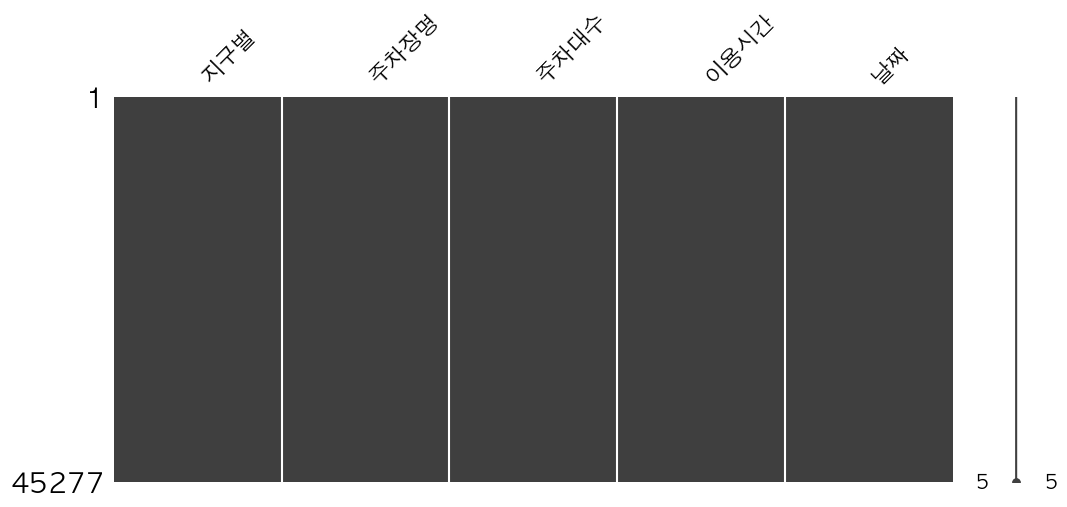

In [89]:
# 결측치 시각화
# train NaN값 시각화
import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(df_day, figsize=(12, 5))

plt.show()

> 주차장 일별 데이터는 결측치가 없는 것을 확인 할 수 있다.

In [63]:
# 날짜 컬럼을 날짜 형식으로 전환
df_day['날짜'] = pd.to_datetime(df_day['날짜'], format= '%Y/%m/%d')

# 일별 날짜 컬럼을 연,월,일 컬럼으로 분리
df_day['연도'] = df_day['날짜'].dt.year
df_day['월'] = df_day['날짜'].dt.month
df_day['일'] = df_day['날짜'].dt.day

df_day

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10
...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15


> 연도,월,일 컬럼을 추가했으므로 날짜 컬럼은 제거한다.

In [58]:
# pip install holidays

In [64]:
# 평일 휴일로 분리 및 요일 변환 
import holidays

# 대한민국 공휴일 가져오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 요일 변환
weekday_map = {0 : '월요일', 1 : '화요일', 2 : '수요일', 3: '목요일', 4: '금요일', 5: '토요일', 6: '일요일'}

# 요일 숫자를 요일 이름으로 변환
df_day['요일'] = df_day['날짜'].dt.weekday.map(weekday_map)

# 날짜가 공휴일인지를 체크하는 함수 추가
df_day['휴일여부'] = df_day['날짜'].apply(lambda x: '휴일' if x in kr_holidays else ('주말' if x.weekday() >= 5 else '평일'))

# 데이터 확인
df_day

,지구별,주차장명,주차대수,이용시간,날짜,연도,월,일,요일,휴일여부
0,PLT-005,뚝섬1주차장,273,22891,2024-11-10,2024,11,10,일요일,주말
1,PLT-011,잠실1주차장,1059,66361,2024-11-10,2024,11,10,일요일,주말
2,PLT-001,강서1주차장,329,26875,2024-11-10,2024,11,10,일요일,주말
3,PLT-008,여의도5주차장,229,22509,2024-11-10,2024,11,10,일요일,주말
4,PLT-008,여의도2주차장,1934,150135,2024-11-10,2024,11,10,일요일,주말
...,...,...,...,...,...,...,...,...,...,...
45272,PLT-008,여의도1주차장,873,221484,2020-01-16,2020,1,16,목요일,평일
45273,PLT-001,강서1주차장,28,347,2020-01-16,2020,1,16,목요일,평일
45274,PLT-008,여의도1주차장,114,6073,2020-01-15,2020,1,15,수요일,평일
45275,PLT-001,강서1주차장,12,68,2020-01-15,2020,1,15,수요일,평일


In [93]:
df_day.to_csv("../Data/서울 일별 주차 통계")

> 날씨 컬럼 추가하기

In [67]:
# 날씨 CSV FILE 불러오기
weather_seoul = pd.read_csv("../Data/서울 날씨(180131~240229).csv", encoding='euc-kr')

# Data 확인하기
weather_seoul

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),일강수량(mm),평균 상대습도(%)
0,108,서울,2018-01-31,-2.6,-5.2,2354.0,0.0,1610,0.67,0.0,54.5
1,108,서울,2018-02-01,-4.0,-8.8,644.0,1.2,1601,NaN,NaN,44.1
2,108,서울,2018-02-02,-2.4,-7.6,723.0,3.8,1440,NaN,NaN,51.1
3,108,서울,2018-02-03,-7.3,-10.4,2347.0,-2.1,17,3.83,0.5,47.0
4,108,서울,2018-02-04,-9.5,-12.8,753.0,-5.2,1607,NaN,NaN,40.9
...,...,...,...,...,...,...,...,...,...,...,...
2216,108,서울,2024-02-25,2.8,0.8,602.0,5.9,1549,10.42,1.8,80.8
2217,108,서울,2024-02-26,3.8,-1.2,656.0,9.7,1414,NaN,NaN,65.3
2218,108,서울,2024-02-27,5.3,1.2,607.0,9.8,1510,NaN,NaN,52.0
2219,108,서울,2024-02-28,6.4,3.2,712.0,10.1,1509,NaN,NaN,59.5
